In [61]:
import numpy as np
import pandas as pd

import yfinance as yf

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

risk_free_rate = 0.03
trial_n = 3

tickers = ['NKE', 'MSFT', 'DIS', 'COST']

start = '2012-1-1'
end = '2022-3-1'

df_close = yf.download(tickers, start, end, interval='1mo')['Close']

df_close.to_csv('./data/df_close.csv')

[*********************100%***********************]  4 of 4 completed


In [62]:
df_close.shape

(122, 4)

In [63]:
df_close.head()

,COST,DIS,MSFT,NKE
Date,,,,
2012-01-01 00:00:00-05:00,82.269997,38.900002,29.530001,25.997499
2012-02-01 00:00:00-05:00,86.059998,41.990002,31.740000,26.980000
2012-03-01 00:00:00-05:00,90.800003,43.779999,32.259998,27.110001
2012-04-01 00:00:00-04:00,88.180000,43.110001,32.020000,27.967501
2012-05-01 00:00:00-04:00,86.389999,45.709999,29.190001,27.045000


In [64]:
df_close.tail()

,COST,DIS,MSFT,NKE
Date,,,,
2021-10-01 00:00:00-04:00,491.540009,169.070007,331.619995,167.289993
2021-11-01 00:00:00-04:00,539.380005,144.899994,330.589996,169.240005
2021-12-01 00:00:00-05:00,567.700012,154.889999,336.320007,166.669998
2022-01-01 00:00:00-05:00,505.130005,142.970001,310.980011,148.070007
2022-02-01 00:00:00-05:00,519.250000,148.460007,298.790009,136.550003


In [65]:
df_close.isnull().sum()

COST    0
DIS     0
MSFT    0
NKE     0
dtype: int64

In [66]:
if df_close.isnull().values.any():
    df_close.fillna(method='ffill', inplace = True) #front fills
    df_close.fillna(method='bfill', inplace = True) #back fills

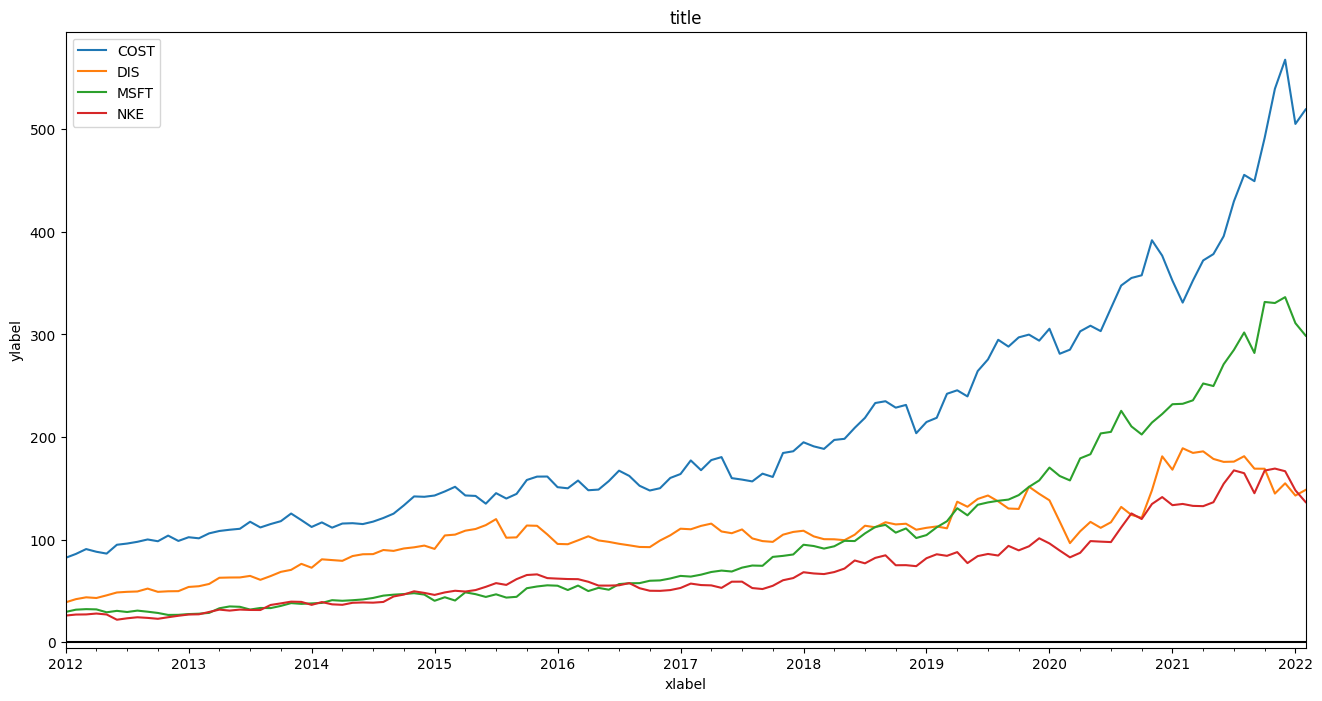

In [67]:
#matplotlib
ax = df_close.plot(title = 'Close Price', figsize=(16, 8), ax = None)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Date')
ax.axhline(y=0, color = 'black')
ax.legend(loc='upper left')
plt.show()

#plotly
fig = px.line(df_close, title = 'Close Price')
fig.update_layout(xaxis_title='Date', yaxis_title='Stock Price',showlegend=True, template='seaborn')
fig.show()

In [69]:
df_pct_change = df_close.pct_change().iloc[1:] #get rid of last row
df_pct_change.head()

,COST,DIS,MSFT,NKE
Date,,,,
2012-02-01 00:00:00-05:00,0.046068,0.079434,0.074839,0.037792
2012-03-01 00:00:00-05:00,0.055078,0.042629,0.016383,0.004818
2012-04-01 00:00:00-04:00,-0.028855,-0.015304,-0.007439,0.031630
2012-05-01 00:00:00-04:00,-0.020299,0.060311,-0.088382,-0.032985
2012-06-01 00:00:00-04:00,0.099664,0.061037,0.047962,-0.188575


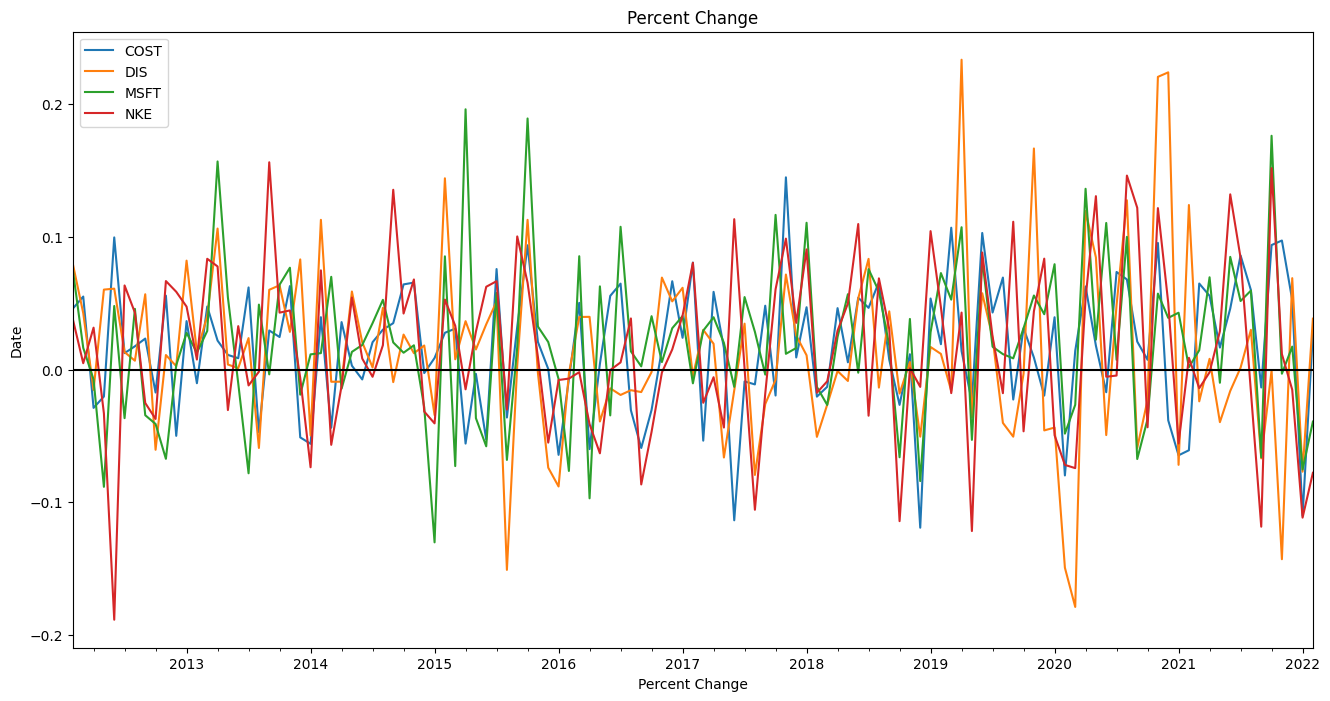

In [83]:
#matplotlib
ax = df_pct_change.plot(title = 'Percent Change', figsize=(16, 8), ax = None)
ax.set_xlabel('Percent Change')
ax.set_ylabel('Date')
ax.axhline(y=0, color = 'black')
ax.legend(loc='upper left')
plt.show()

#plotly
fig = px.line(df_pct_change, title = 'Percent Change')
fig.update_layout(xaxis_title='Date', yaxis_title='Percent Change',showlegend=True, template='seaborn')
fig.show()

In [70]:
mean_return = df_pct_change.mean() * 12
mean_return

COST    0.198531
DIS     0.160302
MSFT    0.251882
NKE     0.190050
dtype: float64

In [71]:
var_risk = df_pct_change.var() * 12
var_risk

COST    0.029159
DIS     0.055223
MSFT    0.041740
NKE     0.049432
dtype: float64

In [72]:
cov_mat = df_pct_change.cov()*12
cov_mat

,COST,DIS,MSFT,NKE
COST,0.029159,0.011473,0.011932,0.012717
DIS,0.011473,0.055223,0.017132,0.020052
MSFT,0.011932,0.017132,0.041740,0.013990
NKE,0.012717,0.020052,0.013990,0.049432


In [73]:
corr_mat = df_pct_change.corr()
corr_mat

,COST,DIS,MSFT,NKE
COST,1.000000,0.285910,0.342005,0.334956
DIS,0.285910,1.000000,0.356845,0.383797
MSFT,0.342005,0.356845,1.000000,0.308000
NKE,0.334956,0.383797,0.308000,1.000000


In [74]:
weight = 1/len(tickers)
eq_weights = [weight for i in tickers]
eq_weights

[0.25, 0.25, 0.25, 0.25]

In [75]:
eq_return = eq_weights @ (mean_return)
eq_return

0.20019129578488354

In [76]:
eq_risk = ((eq_weights @ cov_mat) @ eq_weights)**(1/2)
eq_risk

0.14793324244566944

In [77]:
eq_sharpe = (eq_return - risk_free_rate)/eq_risk
eq_sharpe

1.150460119519037

In [78]:
efficient_frontier_data = []
for trial in range(trial_n):
    t_weight = np.random.random(len(tickers, ))
    t_weights = t_weight/sum(t_weight)
    t_return = t_weights @ (mean_return)
    t_risk = ((t_weights @ cov_mat) @ t_weights)**(1/2)
    t_sharpe = (t_return - risk_free_rate)/t_risk
    efficient_frontier_data.append([t_weights, t_risk, t_return, t_sharpe])

efficient_frontier_data = pd.DataFrame(efficient_frontier_data, columns=['Weights', 'Risk', 'Return', 'Sharpe'])
efficient_frontier_data.head()

,Weights,Risk,Return,Sharpe
0,"[0.32445885367665855, 0.34641750091185247, 0.0...",0.157048,0.183121,0.974994
1,"[0.26028389180134764, 0.3198204468006213, 0.33...",0.150958,0.203546,1.149637
2,"[0.23745363958458088, 0.36053746784852625, 0.3...",0.155880,0.204569,1.119889


In [79]:
i = efficient_frontier_data['Sharpe'].idxmax()
max_sharpe = efficient_frontier_data.iloc[i, :]
max_sharpe

Weights    [0.26028389180134764, 0.3198204468006213, 0.33...
Risk                                                0.150958
Return                                              0.203546
Sharpe                                              1.149637
Name: 1, dtype: object

In [80]:
i = efficient_frontier_data['Risk'].idxmin()
min_risk = efficient_frontier_data.iloc[i, :]
min_risk

Weights    [0.26028389180134764, 0.3198204468006213, 0.33...
Risk                                                0.150958
Return                                              0.203546
Sharpe                                              1.149637
Name: 1, dtype: object

In [81]:
i = efficient_frontier_data['Return'].idxmax()
max_return = efficient_frontier_data.iloc[i, :]
max_return

Weights    [0.23745363958458088, 0.36053746784852625, 0.3...
Risk                                                 0.15588
Return                                              0.204569
Sharpe                                              1.119889
Name: 2, dtype: object